# Experimental Results 3: Meta RL applied to Building Distribution B

In this part of the Bauwerk experiments, we make use of more than a single training task to train our model. First, we set up the building distribution as before.

In [1]:
# Setup and helper code
import bauwerk
import bauwerk.eval
import bauwerk.benchmarks
import gym
import numpy as np

# The length of each task, i.e. how long we aim to 
TASK_LEN = 24*30 # evaluate on 1 month of actions

# Create SolarBatteryHouse environment
build_dist_b = bauwerk.benchmarks.BuildDistB(seed=0, task_ep_len=TASK_LEN)
print(f"Sampled {len(build_dist_b.train_tasks)} training and"
    f" {len(build_dist_b.test_tasks)} test tasks from building distribution B.")

Sampled 20 training and 10 test tasks from building distribution B.


/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Then we use train the SAC implementation in [Stable Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) on 10 different training tasks, one after the other, 18 weeks of training for each task. Overall this means 180 weeks of training (about 3.5 years).

In [2]:
import bauwerk.utils.sb3
from stable_baselines3 import SAC

NUM_TRAIN_STEP_PER_TASK = 24 * 7 * 18

train_env = build_dist_b.make_env()

model_sac = SAC(
    policy="MultiInputPolicy",
    env=train_env, 
    verbose=0,
)

eval_env = build_dist_b.make_env()
eval_env.set_task(build_dist_b.test_tasks[0])
eval_callback = bauwerk.utils.sb3.EvalCallback(
    eval_env=eval_env, 
    eval_len=TASK_LEN, 
    eval_freq=24 * 7
)

# train on each task for NUM_TRAIN_STEP_PER_TASK steps
for i, task in enumerate(build_dist_b.train_tasks[:10]):
    train_env.set_task(task)
    print(f"{i}th env: training on task with battery size {train_env.battery.size:.04f}.")
    model_sac.learn(total_timesteps=NUM_TRAIN_STEP_PER_TASK,callback=[eval_callback])

0th env: training on task with battery size 11.2019.
1th env: training on task with battery size 14.4462.
2th env: training on task with battery size 12.2539.
3th env: training on task with battery size 11.1252.
4th env: training on task with battery size 8.7613.
5th env: training on task with battery size 13.0949.
6th env: training on task with battery size 9.0330.
7th env: training on task with battery size 17.8896.
8th env: training on task with battery size 19.2914.
9th env: training on task with battery size 7.9771.


During training we have recorded the performance on an evaluation environment. In the plot below, we can observe that the training initially gets stuck at the locally optimal policy of not charging at all. About 20k steps into the training it manages to come to a better policy that outperforms this baseline and takes advantage of the flexibility.

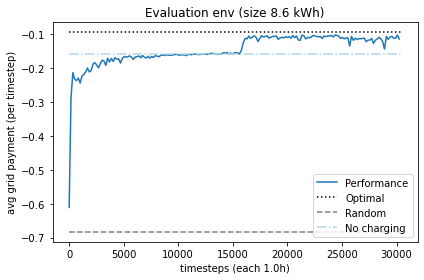

In [3]:
import matplotlib.pyplot as plt

NUM_TRAIN_STEP = len(eval_callback.data) * eval_callback.eval_freq

x = np.arange(0,len(eval_callback.data)*eval_callback.eval_freq,eval_callback.eval_freq)
plt.title(f"Evaluation env (size {eval_env.battery.size:.01f} kWh)")
plt.plot(
    x, eval_callback.data, label="Performance"
)
perf_eval_rand, _ = bauwerk.eval.get_avg_rndm_perf(
        eval_env, 
        eval_len=TASK_LEN,
        num_samples=10,
    )
perf_eval_opt = bauwerk.eval.get_optimal_perf(
    eval_env, 
    eval_len=TASK_LEN
)
perf_nocharge = bauwerk.eval.evaluate_actions(np.zeros((TASK_LEN,1)), eval_env)
plt.hlines(perf_eval_opt, 0, NUM_TRAIN_STEP, label="Optimal", linestyle=":", color="black")
plt.hlines(perf_eval_rand, 0, NUM_TRAIN_STEP, label="Random", linestyle="--", color="grey")
plt.hlines(perf_nocharge, 0, NUM_TRAIN_STEP, label="No charging", linestyle="-.", color="lightblue")
plt.legend()
plt.ylabel(f"avg grid payment (per timestep)")
plt.xlabel(f"timesteps (each {train_env.cfg.time_step_len}h)")
plt.tight_layout()

## Evaluation of agent on task distribution

Next,  we want to evaluate the agent across the entire task distribution, i.e. on houses with battery sizes between 0.5kWh and 20kWh.

In [4]:
# evaluating performance of agent across different battery sizes

dist_env = build_dist_b.make_env()

battery_sizes = np.arange(1,21,1)
perf_per_task = []
opt_perf_per_task = []
for size in battery_sizes:
    task = bauwerk.benchmarks.Task(
        cfg=bauwerk.envs.solar_battery_house.EnvConfig(
            battery_size=size, 
            episode_len=TASK_LEN
        )
    )
    dist_env.set_task(task)
    perf_sac = bauwerk.utils.sb3.eval_model(model_sac, dist_env, eval_len=TASK_LEN)
    perf_opt = bauwerk.eval.get_optimal_perf(dist_env, eval_len=TASK_LEN)
    perf_per_task.append(perf_sac)
    opt_perf_per_task.append(perf_opt)

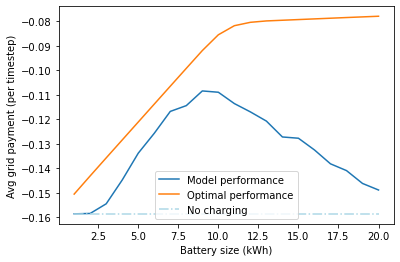

In [5]:
plt.plot(battery_sizes, perf_per_task, label="Model performance")
plt.plot(battery_sizes, opt_perf_per_task, label="Optimal performance")
plt.xlabel("Battery size (kWh)")
plt.ylabel(f"Avg grid payment (per timestep)")
plt.hlines(perf_nocharge, 1, len(battery_sizes), label="No charging", linestyle="-.", color="lightblue")
_ = plt.legend()

> Note for reproducibility: this entire notebook was executed inside the devcontainer of the Bauwerk repository.